In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# --- Sklearn Imports (for Preprocessing, Splitting, and Metrics) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Matplotlib Setup ---
%matplotlib inline
sns.set(style="whitegrid", palette="muted")

print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# --- Configuration ---
# ❗ **ACTION REQUIRED**: Update this to the FULL, ABSOLUTE path to your code folder.
# Example: CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\ML_Project\Classifier_codes'
CLASSIFIER_DIR = r'C:\Users\jaink\OneDrive\Desktop\MLProject\Classifier_codes'
# ---------------------

if not os.path.isdir(CLASSIFIER_DIR):
    print(f"Error: Classifier directory '{CLASSIFIER_DIR}' not found.")
    print("Please update the path in this cell.")
else:
    # Add the folder to the system path to allow imports
    if CLASSIFIER_DIR not in sys.path:
        sys.path.append(os.path.abspath(CLASSIFIER_DIR))
    
    try:
        # Import all 9 of your classifier classes
        from KNN import KNN
        from LogisticRegression import LogisticRegression
        from DecisionTree import DecisionTreeClassifier # Assumes Node class is in this file
        from RandomForest import RandomForestClassifier # Assumes this imports DecisionTree
        from SVM import LinearSVM
        from GaussianNaiveBayes import GaussianNaiveBayes
        from MultiLayerPerceptron import SimpleMLP
        from LinearDiscriminantAnalysis import LDA
        from AdaBoost import AdaBoost # Assumes DecisionStump is in this file
        
        print("✅ Successfully imported all 9 from-scratch classifiers.")
    except ImportError as e:
        print(f"--- 🛑 IMPORT ERROR ---")
        print(f"Error importing classifiers: {e}")
        print("Please check file/class names in your 'Classifier_codes' folder.")
    except Exception as e:
        print(f"An unexpected error occurred during import: {e}")

✅ Successfully imported all 9 from-scratch classifiers.


In [3]:
# This helper class is essential because your target variable 'NObeyesdad'
# is multi-class. It allows your binary-only models (LogReg, SVM, MLP, AdaBoost)
# to work on this problem.

class OvRWrapper:
    """Wraps a binary classifier to support multi-class OvR classification."""
    def __init__(self, binary_classifier_class, **kwargs):
        self.binary_classifier_class = binary_classifier_class
        self.kwargs = kwargs
        self.models = {}
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # This logic is robust: it handles both binary and multi-class cases
        if n_classes <= 2:
            # Standard binary problem
            le = LabelEncoder()
            y_binary = le.fit_transform(y)
            model = self.binary_classifier_class(**self.kwargs)
            model.fit(X, y_binary)
            self.models[le.classes_[1]] = model 
            self.binary_le = le
        else:
            # Multi-class OvR problem
            self.binary_le = None
            for cls in self.classes_:
                y_train_binary = np.where(y == cls, 1, 0)
                model = self.binary_classifier_class(**self.kwargs)
                model.fit(X, y_train_binary)
                self.models[cls] = model
    
    def predict(self, X):
        if self.binary_le:
             # Binary case
             model_key = list(self.models.keys())[0]
             binary_preds = self.models[model_key].predict(X)
             return self.binary_le.inverse_transform(binary_preds)
        else:
            # Multi-class OvR case
            all_scores = []
            for cls in self.classes_:
                model = self.models[cls]
                # Get the best possible score from the binary model
                if hasattr(model, 'predict_proba'):
                    probas = model.predict_proba(X)
                    all_scores.append(probas[:, 1] if probas.ndim == 2 and probas.shape[1] == 2 else probas)
                elif hasattr(model, 'decision_function'):
                    all_scores.append(model.decision_function(X))
                else:
                    all_scores.append(model.predict(X))
            
            scores_matrix = np.stack(all_scores, axis=1)
            best_class_indices = np.argmax(scores_matrix, axis=1)
            return self.classes_[best_class_indices]

print("OvRWrapper class defined.")

OvRWrapper class defined.


In [4]:
# ❗ **ACTION REQUIRED**: Update this path to your CSV file.
# e.g., r'C:\Users\jaink\OneDrive\Desktop\ML_Project\data\obesity_data.csv'
DATA_PATH = r'C:\Users\jaink\OneDrive\Desktop\MLProject\ObesityLevel\ObesityDataSet_raw_and_data_sinthetic.csv'

if not os.path.exists(DATA_PATH):
    print(f"Error: Data file not found at {DATA_PATH}")
    print("Please update the 'DATA_PATH' variable in this cell.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Shape: {df.shape}")

Dataset loaded successfully. Shape: (2111, 17)


In [5]:
print("--- Data Info ---")
df.info()
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF             

In [6]:
print("--- Statistical Summary (Continuous Features) ---")
# Based on the data dictionary
continuous_vars = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
df[continuous_vars].describe()

--- Statistical Summary (Continuous Features) ---


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


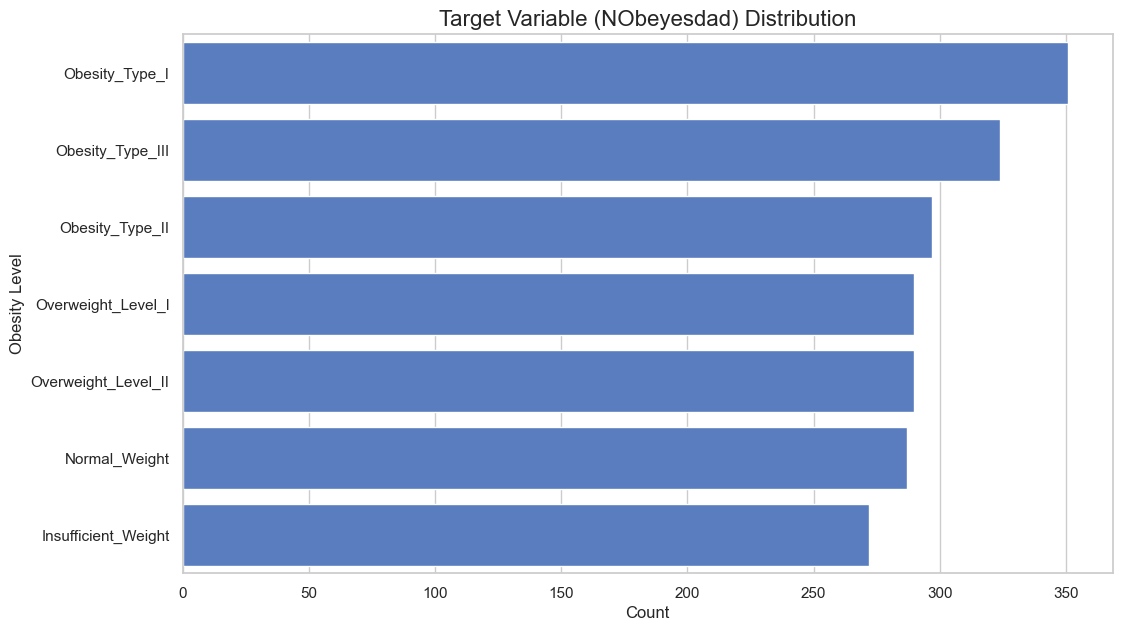

In [7]:
# --- Target Variable: NObeyesdad ---
plt.figure(figsize=(12, 7))
sns.countplot(y='NObeyesdad', data=df, order=df['NObeyesdad'].value_counts().index)
plt.title('Target Variable (NObeyesdad) Distribution', fontsize=16)
plt.xlabel('Count')
plt.ylabel('Obesity Level')
plt.show()

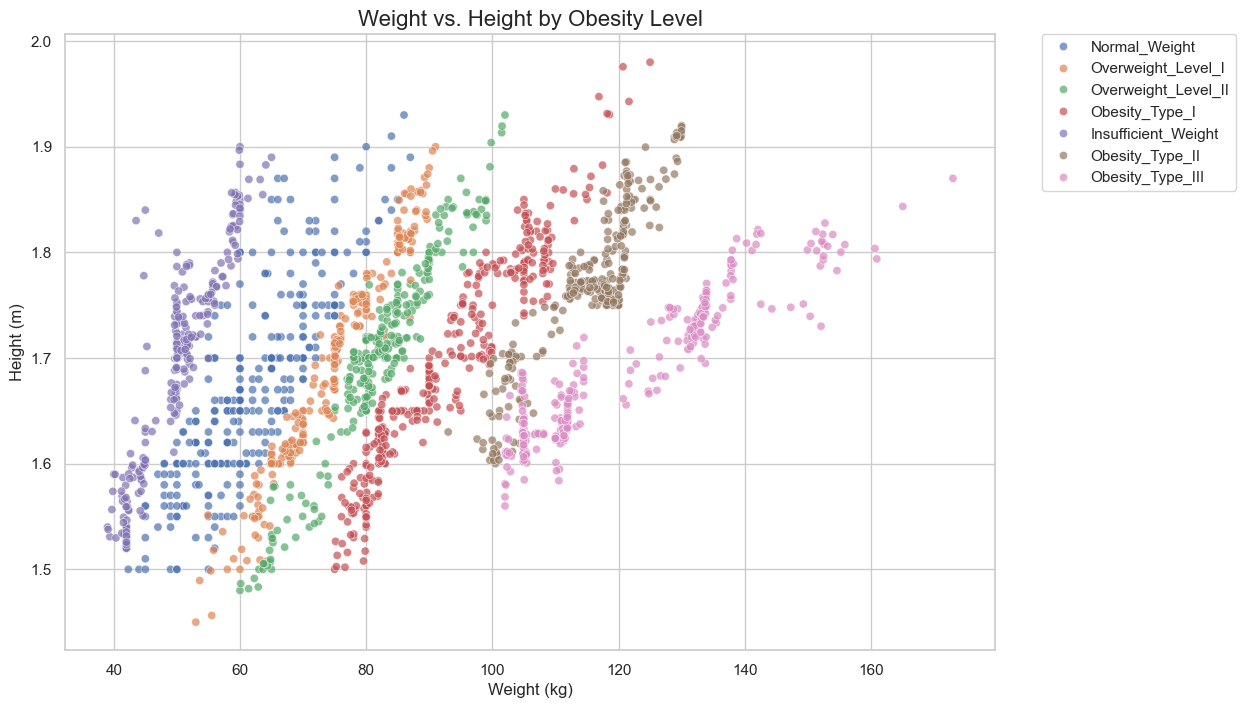

In [8]:
# --- Weight vs. Height, colored by Obesity Level ---

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, 
    x='Weight', 
    y='Height', 
    hue='NObeyesdad',
    alpha=0.7,
    palette='deep'
)
plt.title('Weight vs. Height by Obesity Level', fontsize=16)
plt.xlabel('Weight (kg)')
plt.ylabel('Height (m)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

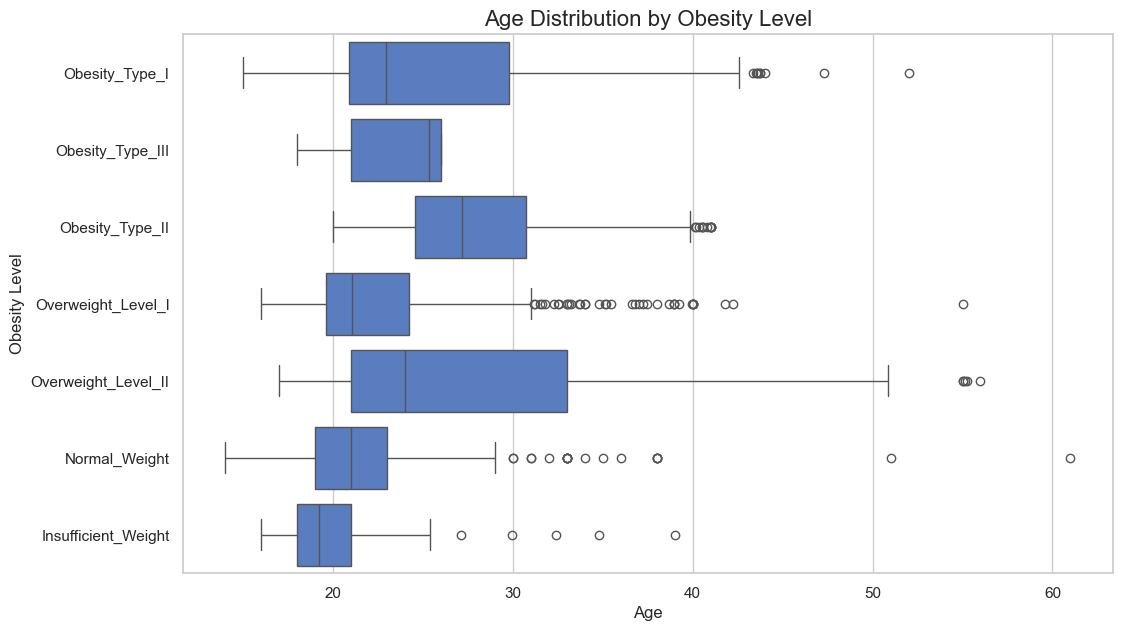

In [9]:
# --- Continuous vs. Target: Age ---
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='Age', y='NObeyesdad', order=df['NObeyesdad'].value_counts().index)
plt.title('Age Distribution by Obesity Level', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Obesity Level')
plt.show()

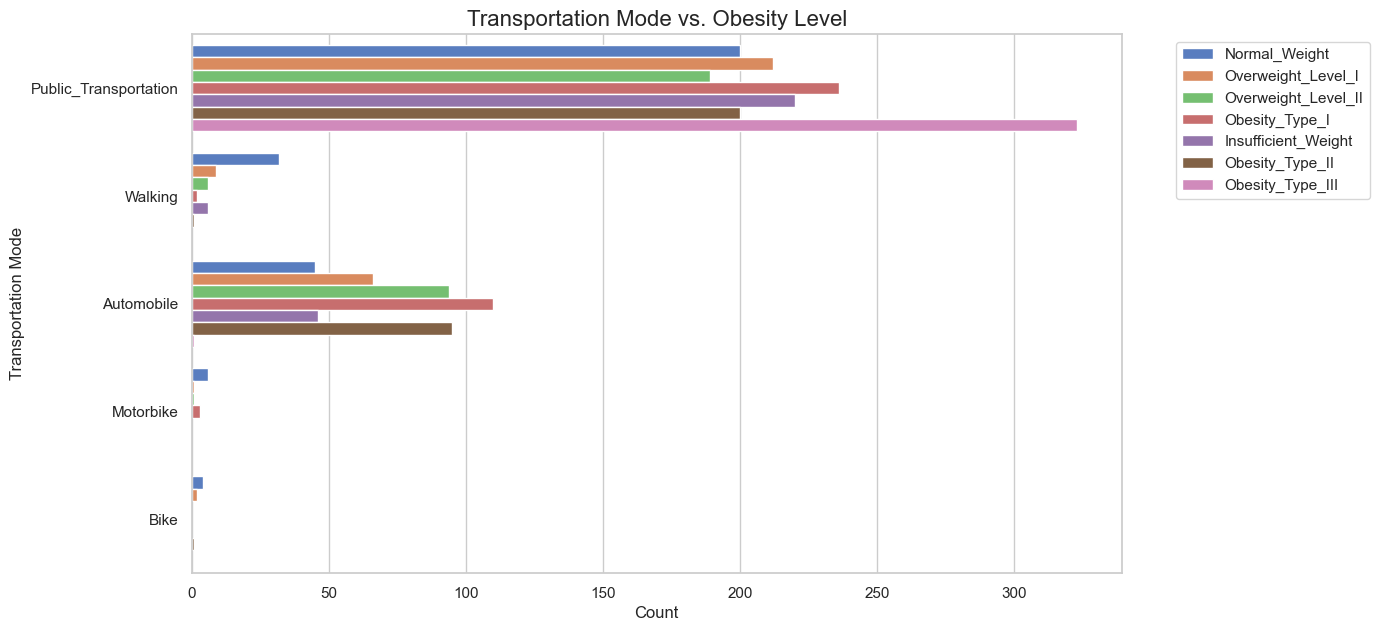

In [10]:
# --- Categorical vs. Target: MTRANS (Transportation) ---
plt.figure(figsize=(12, 7))
sns.countplot(data=df, y='MTRANS', hue='NObeyesdad')
plt.title('Transportation Mode vs. Obesity Level', fontsize=16)
plt.ylabel('Transportation Mode')
plt.xlabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

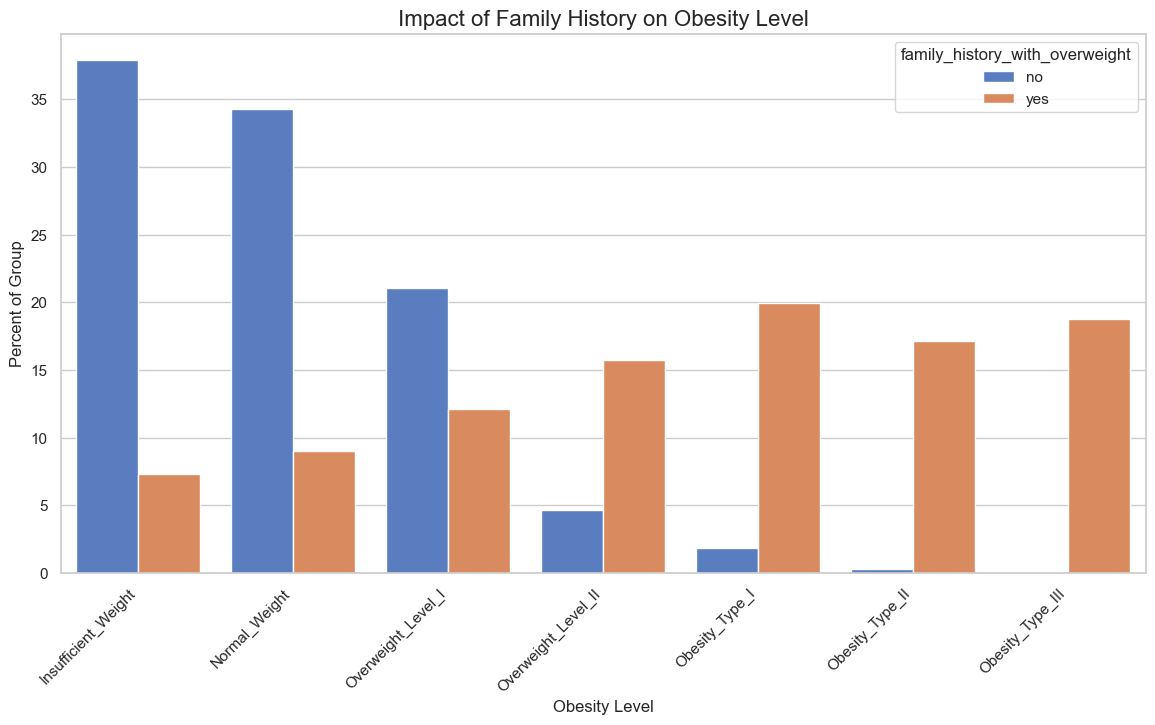

In [11]:
# --- Binary vs. Target: family_history_with_overweight ---
# We'll plot the proportion (percentage) for a clearer view
df_plot = df.groupby('family_history_with_overweight')['NObeyesdad'].value_counts(normalize=True).mul(100).rename('percent').reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=df_plot, x='NObeyesdad', y='percent', hue='family_history_with_overweight')
plt.title('Impact of Family History on Obesity Level', fontsize=16)
plt.xlabel('Obesity Level')
plt.ylabel('Percent of Group')
plt.xticks(rotation=45, ha='right')
plt.show()

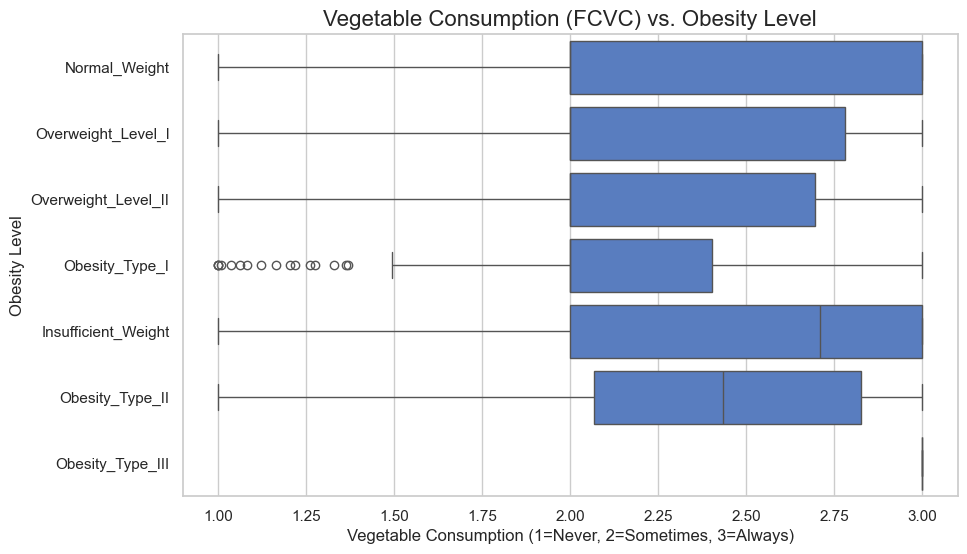

In [12]:
# --- Integer vs. Target: FCVC (Vegetable Consumption) ---
# 1 = Never, 2 = Sometimes, 3 = Always
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='FCVC', y='NObeyesdad')
plt.title('Vegetable Consumption (FCVC) vs. Obesity Level', fontsize=16)
plt.xlabel('Vegetable Consumption (1=Never, 2=Sometimes, 3=Always)')
plt.ylabel('Obesity Level')
plt.show()

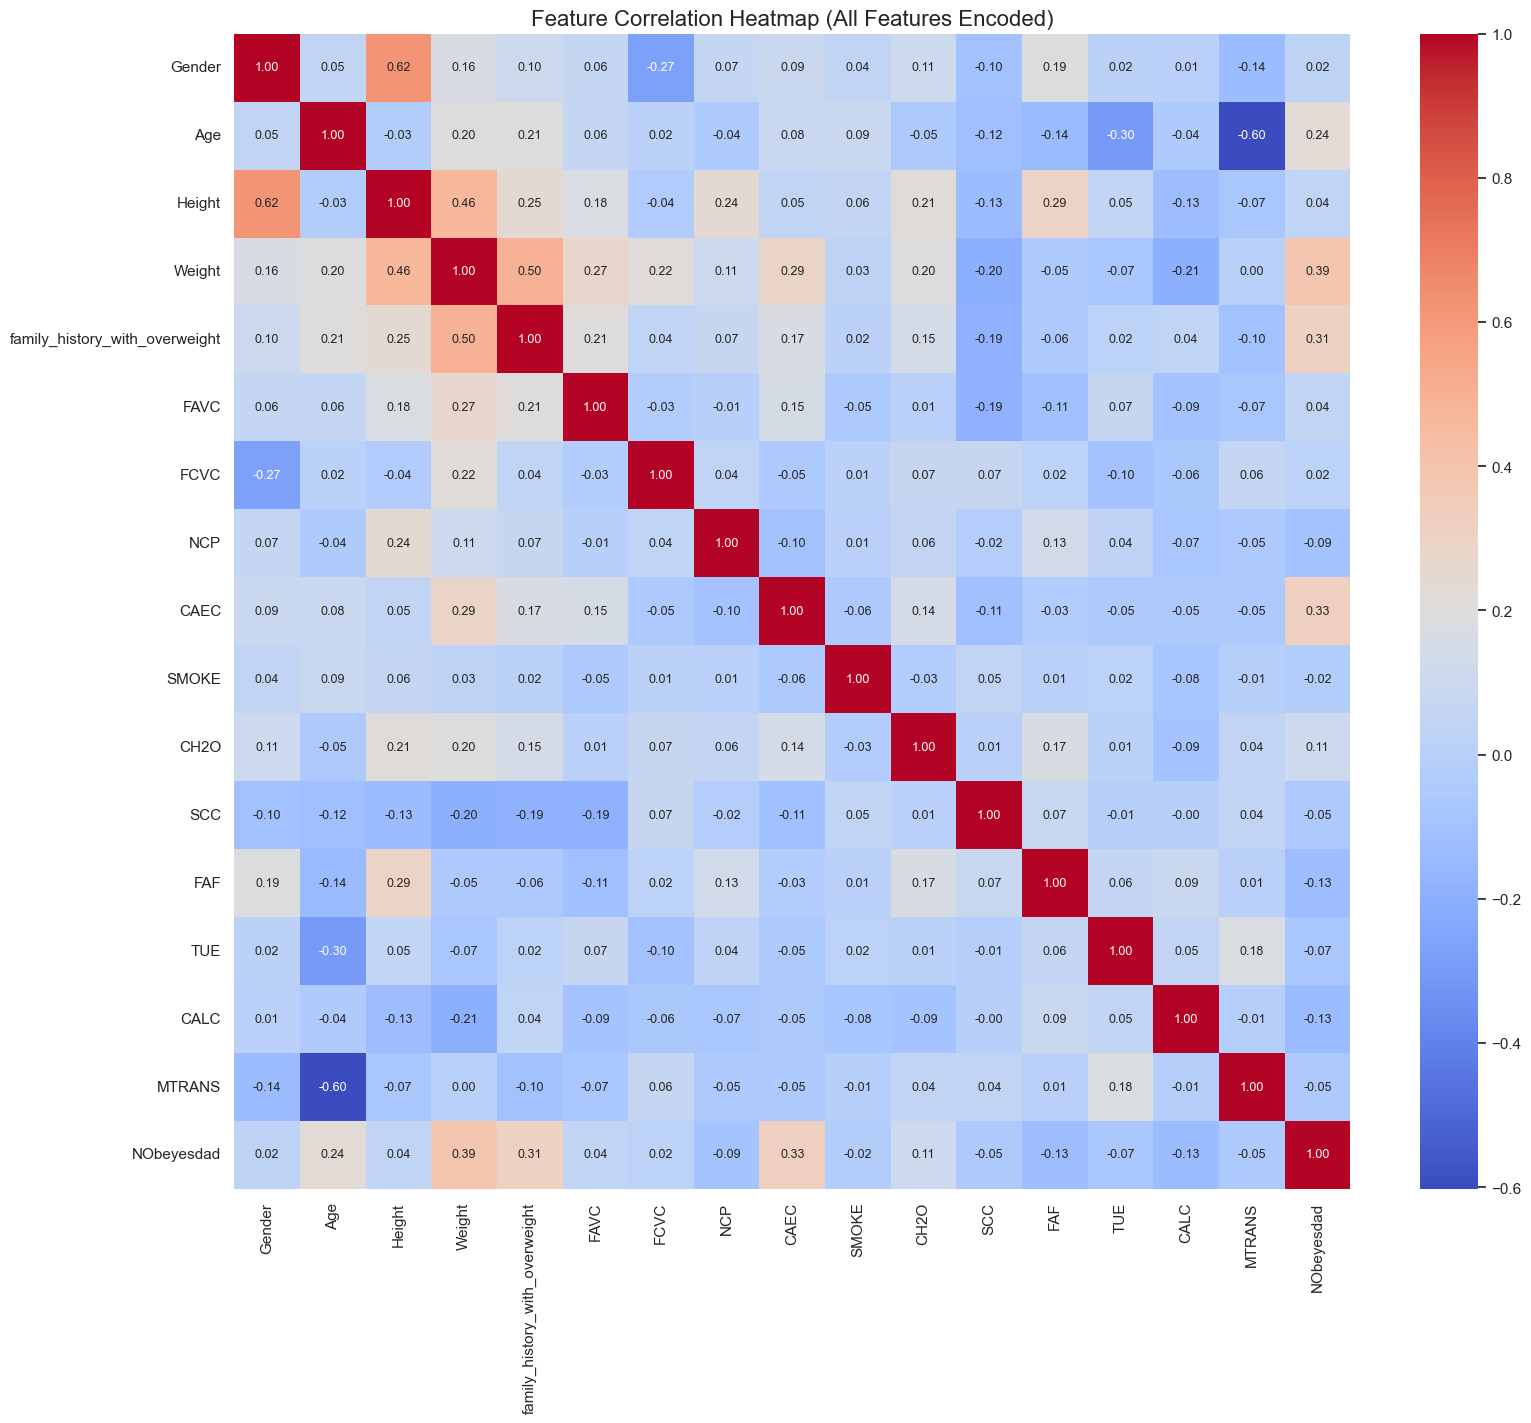

In [13]:
# --- Correlation Heatmap (for all numeric-like features) ---
# We'll LabelEncode all text columns first for this plot
df_corr = df.copy()
for col in df_corr.columns:
    if df_corr[col].dtype == 'object':
        df_corr[col] = LabelEncoder().fit_transform(df_corr[col])

plt.figure(figsize=(18, 15))
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 9})
plt.title('Feature Correlation Heatmap (All Features Encoded)', fontsize=16)
plt.show()

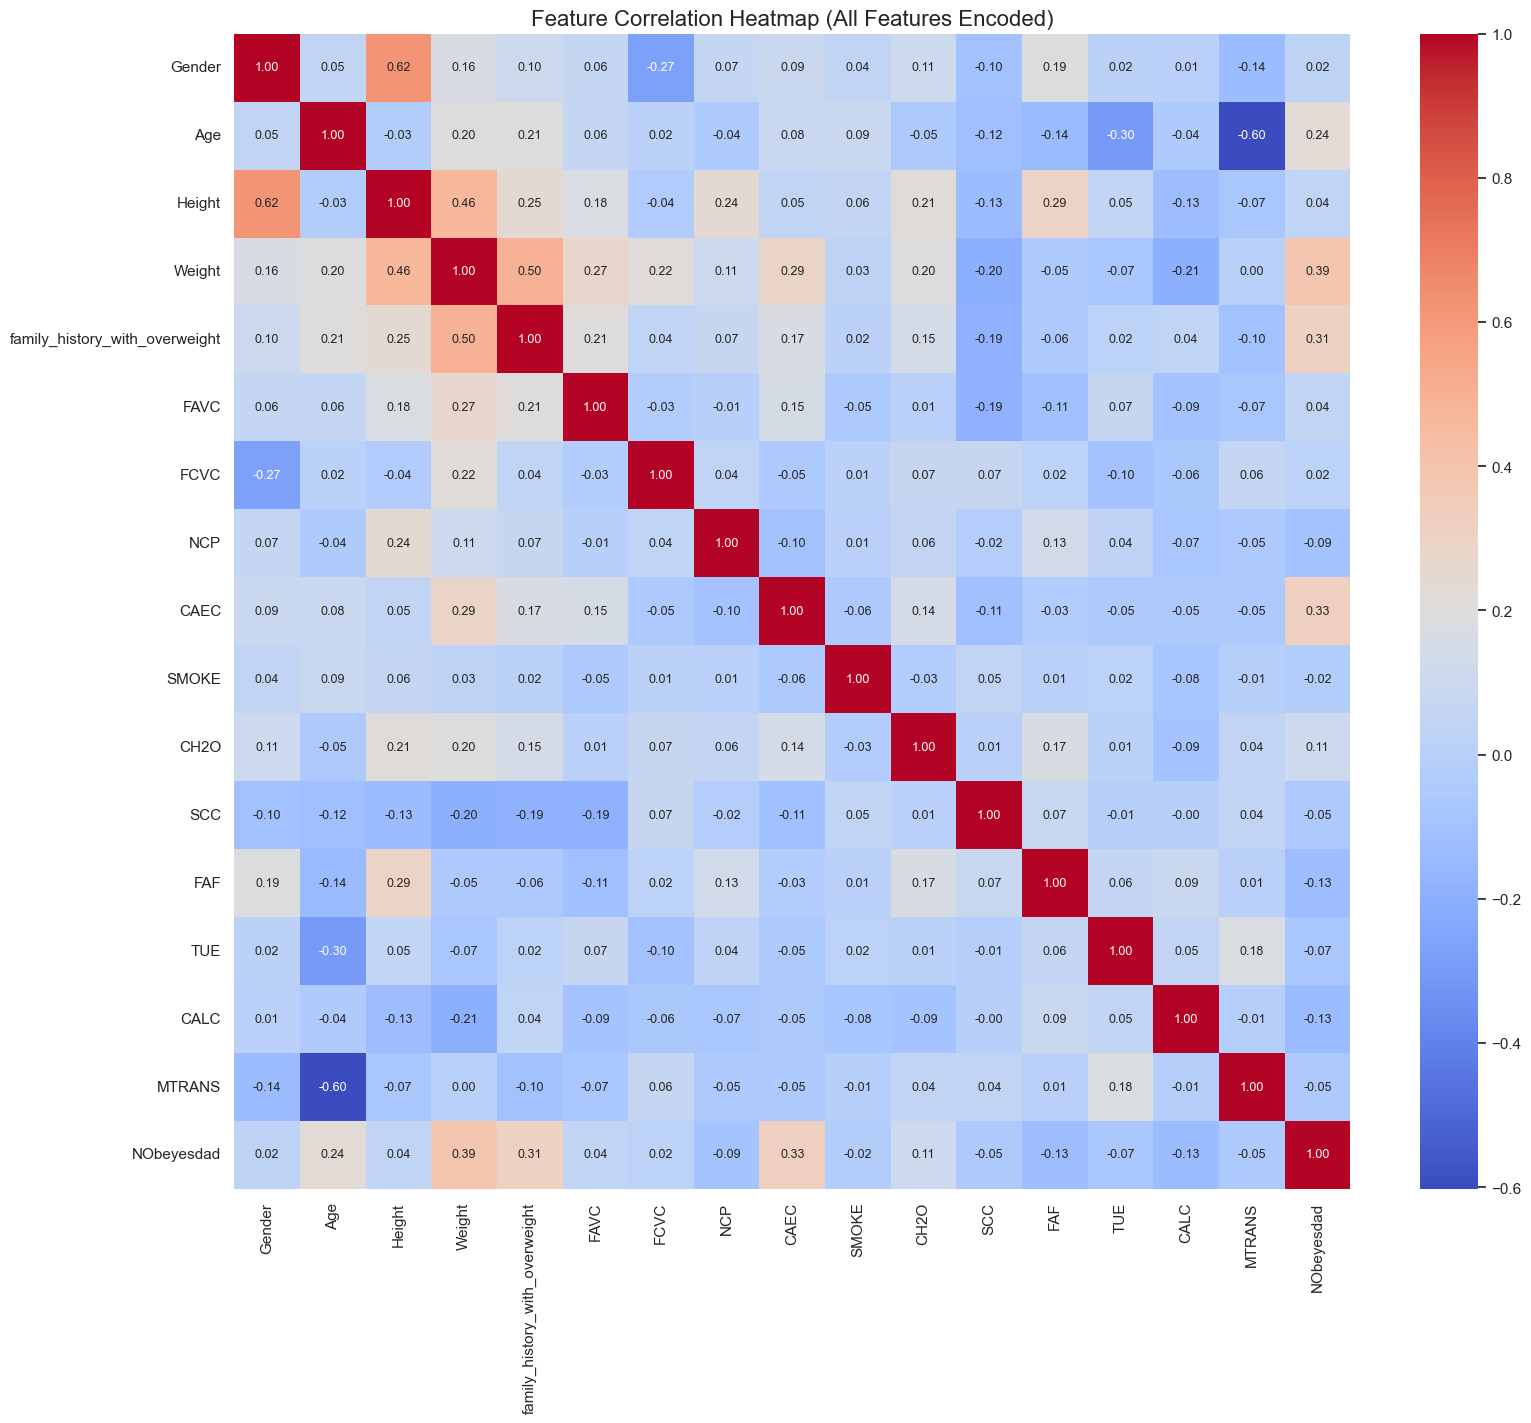

In [14]:
# --- Correlation Heatmap (for all numeric-like features) ---
# We'll LabelEncode all text columns first for this plot
df_corr = df.copy()
for col in df_corr.columns:
    if df_corr[col].dtype == 'object':
        df_corr[col] = LabelEncoder().fit_transform(df_corr[col])

plt.figure(figsize=(18, 15))
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 9})
plt.title('Feature Correlation Heatmap (All Features Encoded)', fontsize=16)
plt.show()

In [15]:
# --- Train-Test Split ---
# Define X (features) and y (target)
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# We use stratify=y because the dataset is imbalanced (see EDA 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1688, 16)
X_test shape: (423, 16)
y_train shape: (1688,)
y_test shape: (423,)


In [16]:
# --- Define Feature Types ---
# Based on the data dictionary and EDA

# Continuous & Ordinal-as-Continuous features to be scaled
CONTINUOUS_FEATURES = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Categorical features to be One-Hot Encoded
CATEGORICAL_FEATURES = ['Gender', 'CAEC', 'CALC', 'MTRANS']

# Binary features to be passed through (after imputation)
BINARY_FEATURES = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

print(f"Total features defined: {len(CONTINUOUS_FEATURES) + len(CATEGORICAL_FEATURES) + len(BINARY_FEATURES)}")
print(f"Original feature count: {X_train.shape[1]}")


# --- Create Preprocessing Pipelines ---

# Pipeline for continuous data: Impute (mean) -> Scale (StandardScaler)
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical data: Impute (most frequent) -> One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipeline for binary data: Impute (most frequent) -> Convert 'yes'/'no' to 1/0
# This transformer is more robust for your binary string columns
class BinaryTransformer(SimpleImputer):
    def transform(self, X, y=None):
        X_imputed = super().transform(X)
        # Convert 'yes'/'no' to 1/0
        if isinstance(X_imputed[0,0], str):
            X_binary = (X_imputed == 'yes').astype(int)
        else: # If already numeric (0/1), just pass
            X_binary = X_imputed.astype(int)
        return X_binary

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Fills missing
    ('binarizer', 'passthrough') # Will handle 0/1, 'yes'/'no' during transform
])

# --- Create the Full ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, CONTINUOUS_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES),
        ('bin', binary_transformer, BINARY_FEATURES)
    ],
    remainder='drop' # Drop any columns not explicitly listed
)

print("Preprocessing pipeline defined.")

Total features defined: 16
Original feature count: 16
Preprocessing pipeline defined.


In [17]:
# --- Apply the Preprocessing Pipeline ---

# Fit on training data and transform it
print("Fitting and transforming X_train...")
# We must convert 'yes'/'no' binary columns to 1/0 before ColumnTransformer
X_train_bin_fixed = X_train.copy()
X_test_bin_fixed = X_test.copy()
for col in BINARY_FEATURES:
    if X_train_bin_fixed[col].dtype == 'object':
        X_train_bin_fixed[col] = X_train_bin_fixed[col].map({'yes': 1, 'no': 0})
        X_test_bin_fixed[col] = X_test_bin_fixed[col].map({'yes': 1, 'no': 0})

X_train_processed = preprocessor.fit_transform(X_train_bin_fixed)
print("Transforming X_test...")
X_test_processed = preprocessor.transform(X_test_bin_fixed)

# --- Get Feature Names After Transformation ---
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(CATEGORICAL_FEATURES)
all_feature_names = CONTINUOUS_FEATURES + list(ohe_feature_names) + BINARY_FEATURES

print(f"\nPreprocessing complete.")
print(f"Original feature count: {X_train.shape[1]}")
print(f"New feature count (after One-Hot Encoding): {X_train_processed.shape[1]}")

# --- Label Encode Target ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
class_names = le.classes_
print(f"Target classes: {class_names}")

Fitting and transforming X_train...
Transforming X_test...

Preprocessing complete.
Original feature count: 16
New feature count (after One-Hot Encoding): 27
Target classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [18]:
# --- Define Model Pipeline ---
print("Defining all 9 from-scratch models...")
n_features_final = X_train_processed.shape[1]

# Models that are multi-class ready (or support it natively)
multi_class_models = {
    "KNN": KNN(k=5),
    "GNB": GaussianNaiveBayes(),
    "LDA": LDA(),
    "DT": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "RF": RandomForestClassifier(n_trees=20, max_depth=10, min_samples_split=5), # Faster params
}

# Binary models wrapped in OvR (needed for this multi-class problem)
binary_models_to_wrap = {
    "LogReg_OvR": (LogisticRegression, 
                   {"learning_rate": 0.01, "n_iters": 200, "verbose": False}), # Faster params
    "SVM_OvR": (LinearSVM, 
                {"learning_rate": 0.001, "lambda_param": 0.01, "n_iters": 200, "verbose": False}), # Faster params
    "MLP_OvR": (SimpleMLP, 
                {"n_input": n_features_final, "n_hidden": 32, "n_output": 1, 
                 "learning_rate": 0.01, "n_iters": 200, "verbose": False, 
                 "activation": 'relu'}),
    "AdaBoost_OvR": (AdaBoost, {"n_estimators": 20}), # Faster params
}

# --- Combine the dictionaries ---
all_models = multi_class_models.copy()
for name, (model_class, kwargs) in binary_models_to_wrap.items():
    all_models[name] = OvRWrapper(model_class, **kwargs)
    
print(f"Total models to train: {len(all_models)}")

Defining all 9 from-scratch models...
Total models to train: 9


In [19]:
# --- Run All Models ---
results = {}
reports = {}
models_trained = {} # To store the trained model instances

print("\n--- Running Model Benchmarks on Processed Data ---")

for name, model in all_models.items():
    try:
        print(f"\n--- Training {name} ---")
        start_time = time.time()
        
        # Train the model on processed data
        model.fit(X_train_processed, y_train_enc)
        
        print(f"  Predicting with {name}...")
        y_pred = model.predict(X_test_processed)
        
        duration = time.time() - start_time
        acc = accuracy_score(y_test_enc, y_pred)
        # Generate report as a dictionary for later use
        report_dict = classification_report(y_test_enc, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        
        results[name] = acc
        reports[name] = report_dict
        models_trained[name] = model # Save the trained model
        
        print(f"  ✅ {name} Accuracy: {acc:<8.4f} (Time: {duration:.2f}s)")
    
    except Exception as e:
        import traceback
        print(f"  ❌ ERROR training/predicting with {name}: {e}")
        traceback.print_exc() 
        results[name] = 0.0
        reports[name] = str(e)


--- Running Model Benchmarks on Processed Data ---

--- Training KNN ---
KNN fitted with 1688 samples.
  Predicting with KNN...
Predicting for 423 samples using KNN (k=5)...
  ✅ KNN Accuracy: 0.8416   (Time: 3.11s)

--- Training GNB ---
Fitting Gaussian Naive Bayes...
Fitting complete.
  Predicting with GNB...
Predicting labels for 423 samples using GNB...
  ✅ GNB Accuracy: 0.5201   (Time: 0.00s)

--- Training LDA ---
Fitting LDA...
LDA fitting complete.
  Predicting with LDA...
Predicting labels for 423 samples using LDA...
  ✅ LDA Accuracy: 0.8889   (Time: 0.02s)

--- Training DT ---
Fitting Decision Tree: max_depth=10, min_split=5, features_per_split=27...
Tree fitting complete.
  Predicting with DT...
Predicting labels for 423 samples using Decision Tree...
  ✅ DT Accuracy: 0.9078   (Time: 3.97s)

--- Training RF ---
Fitting Random Forest: 20 trees, max_depth=10, min_split=5, features_per_split=5...
  Tree 2/20 fitted.
  Tree 4/20 fitted.
  Tree 6/20 fitted.
  Tree 8/20 fitted.
  

In [20]:
# --- Final Results Summary ---

print("\n\n" + "="*30)
print("🏁 FINAL ACCURACY SUMMARY 🏁")
print("="*30 + "\n")

# Convert results to a DataFrame for easy sorting
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print(results_df.to_string())



🏁 FINAL ACCURACY SUMMARY 🏁

          Model  Accuracy
0            RF  0.914894
1            DT  0.907801
2           LDA  0.888889
3           KNN  0.841608
4           GNB  0.520095
5    LogReg_OvR  0.520095
6  AdaBoost_OvR  0.508274
7       SVM_OvR  0.498818
8       MLP_OvR  0.425532


In [21]:
# --- Best Model Classification Report ---

# Get the name and accuracy of the best model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print(f"\n\n--- 🏆 Best Model ---")
print(f"{best_model_name} (Accuracy: {best_accuracy:.4f})")

# --- Print Classification Report for the Best Model ---
print("\n--- Classification Report for Best Model ---")
best_report_dict = reports[best_model_name]
if isinstance(best_report_dict, dict):
    best_report_df = pd.DataFrame(best_report_dict).transpose()
    print(best_report_df)
else:
    print(best_report_dict) # Print error message if it failed



--- 🏆 Best Model ---
RF (Accuracy: 0.9149)

--- Classification Report for Best Model ---
                     precision    recall  f1-score     support
Insufficient_Weight   1.000000  0.870370  0.930693   54.000000
Normal_Weight         0.768116  0.913793  0.834646   58.000000
Obesity_Type_I        0.893333  0.957143  0.924138   70.000000
Obesity_Type_II       0.983333  0.983333  0.983333   60.000000
Obesity_Type_III      1.000000  0.984615  0.992248   65.000000
Overweight_Level_I    0.888889  0.827586  0.857143   58.000000
Overweight_Level_II   0.907407  0.844828  0.875000   58.000000
accuracy              0.914894  0.914894  0.914894    0.914894
macro avg             0.920154  0.911667  0.913886  423.000000
weighted avg          0.920258  0.914894  0.915643  423.000000
